*******************************************************************************
Distribution authorized to U.S. Government agencies and their contractors. Other requests for 
 this document shall be referred to the MIT Lincoln Laboratory Technology Office.

This material is based upon work supported by the Under Secretary of Defense for Research and 
Engineering under Air Force Contract No. FA8702-15-D-0001. Any opinions, findings, conclusions
or recommendations expressed in this material are those of the author(s) and do not necessarily 
reflect the views of the Under Secretary of Defense for Research and Engineering.

© 2019 Massachusetts Institute of Technology.
The software/firmware is provided to you on an As-Is basis

 Delivered to the U.S. Government with Unlimited Rights, as defined in DFARS Part 252.227-7013 
or 7014 (Feb 2014). Notwithstanding any copyright notice, U.S. Government rights in this work 
are defined by DFARS 252.227-7013 or DFARS 252.227-7014 as detailed above. Use of this work other 
than as specifically authorized by the U.S. Government may violate any copyrights that exist in 
this work.
**************************************************************************************************


In [1]:
import socket
import cv2
import numpy as np
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random
import time
import struct
import math

# Setup basic information

In [2]:
# port that the simulation is listening on
request_port = 9000
receive_port = 9001

# ip address of the simulation
client_ip = "172.25.183.58"
self_ip = "172.25.183.58"

# Test teleport movement

In [3]:
x_distance = 0
z_distance = 1
dtheta_y = 0

#tag for teleport movement requests is 'TLPT'
tag = 'TLPT'
# the format for the teleport movement request is
# [(4 char)tag, (float)x_distance, (float)z_distance, (float)dtheta_y]
#where x_distance and z_distance are in meters in body frame and theta_y is rotation in degrees around the y-axis
payload = bytearray()
payload.extend( tag.encode() )
payload.extend( struct.pack("f", x_distance) )
payload.extend( struct.pack("f", z_distance) )
payload.extend( struct.pack("f", dtheta_y) )

pos_socket = socket.socket(socket.AF_INET, socket.SOCK_DGRAM) # udp socket
pos_socket.sendto( payload, (client_ip, request_port) )
pos_socket.close()

# Test force movement

In [4]:
z_force = 0
y_torque = 10

#tag for force movement is 'xBFF'
tag = 'xBFF'
# the format for the force movement request is
# [(4 char)tag, (float)z_force, (float)y_torque]
#where z_force is in units? and will be applied to the z axis in body frame 
#and y_torque is in units? and will be applied around the y axis in body frame
payload = bytearray()
payload.extend( tag.encode() )
payload.extend( struct.pack("f", z_force) )
payload.extend( struct.pack("f", y_torque) )

request_socket = socket.socket(socket.AF_INET, socket.SOCK_DGRAM) # udp socket
request_socket.sendto( payload, (client_ip, request_port) )
request_socket.close()

# Test Image Requests without Metadata

<TESSE Agent Metadata v0.1>
  <position x='-41.31866/' y='-4.650269' z='6.563552'/>
  <quaternion x='0/' y='0.04361939' z='0' w='0.9990482'/>
  <velocity x_dot='0/' y_dot='0.006237643' z_dot='0'/>
  <angular velocity x_ang_dot='0/' y_ang_dot='0' z_ang_dot ='0'/>
  <acceleration x_ddot='0/' y_ddot='0.2798378' z_ddot='0'/>
  <angular acceleration x_ang_ddot='0/' y_ang_ddot='0' z_ang_ddot='0'/>
  <time>14.47994</time>
  <collision status='false' name=''/>
</TESSE Agent Metadata v0.1>



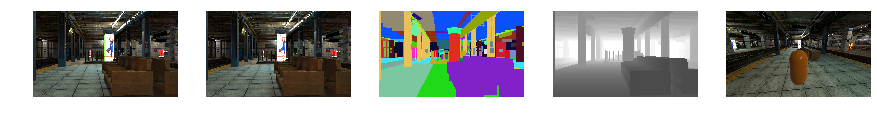

In [60]:
# setup tcp listener - images will be sent over tcp to reduce likelihood of data corruption
receive_socket = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
receive_socket.setsockopt(socket.SOL_SOCKET, socket.SO_REUSEADDR, 1)
receive_socket.settimeout(15)
receive_socket.bind((self_ip,receive_port))
receive_socket.listen(1)


#image request without metadata tag is rIMG
#tag = 'rIMG' 
#image request with metadata tag is tIMG
tag = 'tIMG'
# the message format is as follows
#[(4 char)tag, (int32) camera_index 1, (int32)compressed, (int32)single channel]
#[(4 char)tag, (int32) camera_index 2, (int32)compressed, (int32)single channel]
#etc. for each camera requested
# compressed is a flag to received compressed images (1 for compressed), 
#'single channel' is a flag to receive only one channel images (1 for single channel),
#currently you can request compressed OR single channel, but not single channel, compressed images
# Camera indexes are currently as folI basi
# 1: rgb right
# 2: segmentation
# 3: depth
# 4: third person
payload = bytearray()
payload.extend( tag.encode() )
payload.extend( bytearray(struct.pack('I', 0)) ) # first image camera id 
payload.extend( bytearray(struct.pack('I', 0)) ) # first image compression flag
payload.extend( bytearray(struct.pack('I', 0)) ) # first image single channel flag
payload.extend( bytearray(struct.pack('I', 1)) ) # second image camera id
payload.extend( bytearray(struct.pack('I', 0)) ) # second image compression flag
payload.extend( bytearray(struct.pack('I', 0)) ) # second image single channel flag
payload.extend( bytearray(struct.pack('I', 2)) ) # third image camera id
payload.extend( bytearray(struct.pack('I', 0)) ) # third image compression flag
payload.extend( bytearray(struct.pack('I', 0)) ) # third image single channel flag
payload.extend( bytearray(struct.pack('I', 3)) ) # fourth image camera id
payload.extend( bytearray(struct.pack('I', 0)) ) # fourth image compression flag
payload.extend( bytearray(struct.pack('I', 0)) ) # fourth image single channel flag
payload.extend( bytearray(struct.pack('I', 4)) ) # fifth image camera id
payload.extend( bytearray(struct.pack('I', 0)) ) # fifth image compression flag
payload.extend( bytearray(struct.pack('I', 0)) ) # fifth image single channel flag


# send request to simulation
request_socket = socket.socket(socket.AF_INET, socket.SOCK_DGRAM) # udp socket
request_socket.sendto( payload, (client_ip, request_port) )
request_socket.close()

"""
response will come back from Unity as a byte array containing the following
[multi image payload header][img 1 header][img 1 payload][img 2 header][img 2 payload]...[img N header][img N payload][bounding_box_metadata][image bounds metadata]

[multi image payload header] = 8 bytes, ["mult"(byte[4]), total payload length(uint32)]
[img header] = 32 bytes, ["uImG"(byte[4]), image payload length(uint32), image width(uint32), image height(uint32), camera id(uint32), image_type(byte[4]),0(uint32),0(uint32)]
[img payload] = byte array of image data
"""

# get the information
#try:
# first, get the image header info
payload_header_size = 12
img_header_size = 32
conn, addr = receive_socket.accept()
data = conn.recv(payload_header_size)

#print(len(data))
# ensure this is a valid tag
tag = data[0:4].decode("utf-8")
#print("got tag " + tag)
payload_length_imgs = struct.unpack("I",data[4:8])[0]
payload_length_meta = struct.unpack("I",data[8:12])[0]

#print("payload length images {}".format(payload_length_imgs))
#print("payload length metadata {}".format(payload_length_meta))

imgs = []
cam_ids = []
try:
    if( tag == "mult" ):
        total_data_received = 0

        while( total_data_received < payload_length_imgs ):
            # get the header payload
            #print("fetching data...")
            data = conn.recv( img_header_size )
            total_data_received += len(data)
            if( data[0:4].decode("utf-8") == "uImG" ):
                # get the rest of the image metadata
                img_payload_length = struct.unpack("I",data[4:8])[0]
                img_width = struct.unpack("I",data[8:12])[0]
                img_height = struct.unpack("I",data[12:16])[0]
                cam_id = struct.unpack("I",data[16:20])[0]
                img_type = data[20:24].decode("utf-8")

            img_payload = bytearray()
            while( len(img_payload) < img_payload_length ):
                img_payload.extend( conn.recv(img_payload_length - len(img_payload)) )

            total_data_received += len(img_payload)

            if( img_type == 'xRGB' ):
                img = np.flip(np.ndarray((img_height,img_width,3),buffer=img_payload,dtype='uint8'),0)
            elif( img_type == 'xGRY' ):
                img = np.flip(np.ndarray((img_height,img_width),buffer=img_payload,dtype='uint8'),0)
            elif( img_type == 'cRGB'):
                ndarr = np.frombuffer(img_payload, dtype=np.uint8)
                img = cv2.imdecode(ndarr, cv2.IMREAD_UNCHANGED)
                img = img[:,:,[2,1,0]]

            imgs.append(img)
            cam_ids.append(cam_id)

        meta_payload = bytearray()
        if( total_data_received > payload_length_imgs ):
            print("already got the metadata, just need to extract it")
            if( total_data_received == (payload_length_imgs + payload_length_meta) ):
                meta_payload = img_payload[img_payload_length:]
            elif( total_data_received < (payload_length_imgs + payload_length_meta) ):
                print("need to get the rest of the metadata")
                data = conn.recv( (payload_length_imgs + payload_length_meta) - total_data_received )
                meta_payload = img_payload[img_payload_length:]
                meta_payload.extend(data)
        elif( total_data_received == payload_length_imgs ):
            data = conn.recv( payload_length_meta )
            meta_payload.extend(data)


        #print( "{},{}".format(img_width,img_height) )
        print(meta_payload.decode("utf-8"))
        conn.close()
except:
    print("failed!")
    receive_socket.close()
    conn.close()
    
    
receive_socket.close()
if( len(imgs) > 1 ):
    fig, ax = plt.subplots(1,len(imgs),figsize=(15,10))
    for i in range(len(imgs)):
        ax[i].axis('off')
        ax[i].imshow(imgs[i])
else:
    plt.imshow(imgs[0])
    plt.axis('off')

plt.show()
    


# Test Metadata Requests

In [6]:
# setup tcp listener - metadata will be sent over tcp to reduce likelihood of data corruption
receive_socket = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
receive_socket.setsockopt(socket.SOL_SOCKET, socket.SO_REUSEADDR, 1)
receive_socket.settimeout(15)
receive_socket.bind((self_ip,receive_port))
receive_socket.listen(1)

#tag for metadata request is 'rMET'
tag = 'rMET'
# the format for the force movement request is
# [(4 char)tag]

payload = bytearray()
payload.extend( tag.encode() )

request_socket = socket.socket(socket.AF_INET, socket.SOCK_DGRAM) # udp socket
request_socket.sendto( payload, (client_ip, request_port) )
request_socket.close()

# listen for response on tcp socket
payload_header_size = 8
conn, addr = receive_socket.accept()
data = conn.recv(payload_header_size)

try:
    # process header information
    tag = data[0:4].decode("utf-8")
    payload_length_meta = struct.unpack("I",data[4:8])[0]
    if( tag == "meta" ):
        # process metadata payload
        meta_payload = bytearray()
        while( len(meta_payload) < payload_length_meta ):
            data = conn.recv( payload_length_meta )
            meta_payload.extend(data)
except:
    print("failed!")
    receive_socket.close()
    conn.close()

print(meta_payload.decode("utf-8"))
conn.close()

receive_socket.close()

<TESSE Agent Metadata v0.1>
  <position x='0.3200458/' y='2.349921' z='26.72625'/>
  <quaternion x='0/' y='-0.2987175' z='0' w='-0.9543417'/>
  <velocity x_dot='-7.306467E-11/' y_dot='0.002646162' z_dot='-5.070788E-11'/>
  <angular velocity x_ang_dot='0/' y_ang_dot='0.6497258' z_ang_dot ='0'/>
  <acceleration x_ddot='1.107649E-10/' y_ddot='-0.1549999' z_ddot='6.909404E-13'/>
  <angular acceleration x_ang_ddot='0/' y_ang_ddot='-0.6765157' z_ang_ddot='0'/>
  <time>9.607864</time>
  <collision status='false' name=''/>
</TESSE Agent Metadata v0.1>



# Test Get Camera Information Request

In [7]:
# setup tcp listener - metadata will be sent over tcp to reduce likelihood of data corruption
receive_socket = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
receive_socket.setsockopt(socket.SOL_SOCKET, socket.SO_REUSEADDR, 1)
receive_socket.settimeout(15)
receive_socket.bind((self_ip,receive_port))
receive_socket.listen(1)

#tag for metadata request is 'rMET'
tag = 'gCaI'
# the format for the force movement request is
# [(4 char)tag]

payload = bytearray()
payload.extend( tag.encode() )
payload.extend( bytearray(struct.pack('i', -1)) ) # first image camera id 

request_socket = socket.socket(socket.AF_INET, socket.SOCK_DGRAM) # udp socket
request_socket.sendto( payload, (client_ip, request_port) )
request_socket.close()
#try:
# listen for response on tcp socket
payload_header_size = 8
conn, addr = receive_socket.accept()
data = conn.recv(payload_header_size)

try:
    # process header information
    tag = data[0:4].decode("utf-8")
    payload_length_meta = struct.unpack("I",data[4:8])[0]
    if( tag == "cami" ):
        # process metadata payload
        meta_payload = bytearray()
        while( len(meta_payload) < payload_length_meta ):
            data = conn.recv( payload_length_meta )
            meta_payload.extend(data)        
except:
    print("failed!")
    receive_socket.close()
    conn.close()

print(meta_payload.decode("utf-8"))
conn.close()

receive_socket.close()

<camera_info>
  <name>rgb_left</name>
  <id>0</id>
  <parameters height='726' width='1215'fov='37.84929'/>
  <position x='-0.05' y='0' z='0'/>
  <rotation x='0' y='0' z='0' w='1'/>
</camera_info>
<camera_info>
  <name>rgb_right</name>
  <id>1</id>
  <parameters height='726' width='1215'fov='37.84929'/>
  <position x='0.05' y='0' z='0'/>
  <rotation x='0' y='0' z='0' w='1'/>
</camera_info>
<camera_info>
  <name>segmentation</name>
  <id>2</id>
  <parameters height='726' width='1215'fov='37.84929'/>
  <position x='0.05' y='0' z='0'/>
  <rotation x='0' y='0' z='0' w='1'/>
</camera_info>
<camera_info>
  <name>depth</name>
  <id>3</id>
  <parameters height='726' width='1215'fov='37.84929'/>
  <position x='0.05' y='0' z='0'/>
  <rotation x='0' y='0' z='0' w='1'/>
</camera_info>
<camera_info>
  <name>3pv</name>
  <id>4</id>
  <parameters height='726' width='1215'fov='90'/>
  <position x='0' y='1.319' z='-2.258'/>
  <rotation x='0.1100685' y='0' z='0' w='0.993924'/>
</camera_info>



# Test Set Camera Parameters Request

In [8]:
# setup tcp listener - metadata will be sent over tcp to reduce likelihood of data corruption
receive_socket = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
receive_socket.setsockopt(socket.SOL_SOCKET, socket.SO_REUSEADDR, 1)
receive_socket.settimeout(15)
receive_socket.bind((self_ip,receive_port))
receive_socket.listen(1)

#tag for metadata request is 'rMET'
tag = 'sCaR'
# the format for the force movement request is
# [(4 char)tag]

payload = bytearray()
payload.extend( tag.encode() )
payload.extend( bytearray(struct.pack('i', 720)) )
payload.extend( bytearray(struct.pack('i', 340)) )
payload.extend( bytearray(struct.pack('f', 60.0)) )
payload.extend( bytearray(struct.pack('i', -1)) ) # first image camera id 

request_socket = socket.socket(socket.AF_INET, socket.SOCK_DGRAM) # udp socket
request_socket.sendto( payload, (client_ip, request_port) )
request_socket.close()
#try:
# listen for response on tcp socket
payload_header_size = 8
conn, addr = receive_socket.accept()
data = conn.recv(payload_header_size)

try:
    # process header information
    tag = data[0:4].decode("utf-8")
    payload_length_meta = struct.unpack("I",data[4:8])[0]
    if( tag == "cami" ):
        # process metadata payload
        meta_payload = bytearray()
        while( len(meta_payload) < payload_length_meta ):
            data = conn.recv( payload_length_meta )
            meta_payload.extend(data)        
except:
    print("failed!")
    receive_socket.close()
    conn.close()

print(meta_payload.decode("utf-8"))
conn.close()

receive_socket.close()

<camera_info>
  <name>rgb_left</name>
  <id>0</id>
  <parameters height='720' width='340'fov='60'/>
  <position x='-0.05' y='0' z='0'/>
  <rotation x='0' y='0' z='0' w='1'/>
</camera_info>
<camera_info>
  <name>rgb_right</name>
  <id>1</id>
  <parameters height='720' width='340'fov='60'/>
  <position x='0.05' y='0' z='0'/>
  <rotation x='0' y='0' z='0' w='1'/>
</camera_info>
<camera_info>
  <name>segmentation</name>
  <id>2</id>
  <parameters height='720' width='340'fov='60'/>
  <position x='0.05' y='0' z='0'/>
  <rotation x='0' y='0' z='0' w='1'/>
</camera_info>
<camera_info>
  <name>depth</name>
  <id>3</id>
  <parameters height='720' width='340'fov='60'/>
  <position x='0.05' y='0' z='0'/>
  <rotation x='0' y='0' z='0' w='1'/>
</camera_info>
<camera_info>
  <name>3pv</name>
  <id>4</id>
  <parameters height='720' width='340'fov='60'/>
  <position x='0' y='1.319' z='-2.258'/>
  <rotation x='0.1100685' y='0' z='0' w='0.993924'/>
</camera_info>



# Test Set Camera Relative Position Request

In [9]:
# setup tcp listener - metadata will be sent over tcp to reduce likelihood of data corruption
receive_socket = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
receive_socket.setsockopt(socket.SOL_SOCKET, socket.SO_REUSEADDR, 1)
receive_socket.settimeout(15)
receive_socket.bind((self_ip,receive_port))
receive_socket.listen(1)

#tag for metadata request is 'rMET'
tag = 'sCaP'
# the format for the force movement request is
# [(4 char)tag]

payload = bytearray()
payload.extend( tag.encode() )
payload.extend( bytearray(struct.pack('f', 1)) )
payload.extend( bytearray(struct.pack('f', -.05)) )
payload.extend( bytearray(struct.pack('f', 1)) )
payload.extend( bytearray(struct.pack('i', -1)) ) # first image camera id 

request_socket = socket.socket(socket.AF_INET, socket.SOCK_DGRAM) # udp socket
request_socket.sendto( payload, (client_ip, request_port) )
request_socket.close()
#try:
# listen for response on tcp socket
payload_header_size = 8
conn, addr = receive_socket.accept()
data = conn.recv(payload_header_size)

try:
    # process header information
    tag = data[0:4].decode("utf-8")
    payload_length_meta = struct.unpack("I",data[4:8])[0]
    if( tag == "cami" ):
        # process metadata payload
        meta_payload = bytearray()
        while( len(meta_payload) < payload_length_meta ):
            data = conn.recv( payload_length_meta )
            meta_payload.extend(data)        
except:
    print("failed!")
    receive_socket.close()
    conn.close()

print(meta_payload.decode("utf-8"))
conn.close()

receive_socket.close()

<camera_info>
  <name>rgb_left</name>
  <id>0</id>
  <parameters height='720' width='340'fov='60'/>
  <position x='1' y='-0.05' z='1'/>
  <rotation x='0' y='0' z='0' w='1'/>
</camera_info>
<camera_info>
  <name>rgb_right</name>
  <id>1</id>
  <parameters height='720' width='340'fov='60'/>
  <position x='1' y='-0.05' z='1'/>
  <rotation x='0' y='0' z='0' w='1'/>
</camera_info>
<camera_info>
  <name>segmentation</name>
  <id>2</id>
  <parameters height='720' width='340'fov='60'/>
  <position x='1' y='-0.05' z='1'/>
  <rotation x='0' y='0' z='0' w='1'/>
</camera_info>
<camera_info>
  <name>depth</name>
  <id>3</id>
  <parameters height='720' width='340'fov='60'/>
  <position x='1' y='-0.05' z='1'/>
  <rotation x='0' y='0' z='0' w='1'/>
</camera_info>
<camera_info>
  <name>3pv</name>
  <id>4</id>
  <parameters height='720' width='340'fov='60'/>
  <position x='1' y='-0.05' z='1'/>
  <rotation x='0.1100685' y='0' z='0' w='0.993924'/>
</camera_info>



# Test Set Camera Relative Rotation Request

In [10]:
# setup tcp listener - metadata will be sent over tcp to reduce likelihood of data corruption
receive_socket = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
receive_socket.setsockopt(socket.SOL_SOCKET, socket.SO_REUSEADDR, 1)
receive_socket.settimeout(15)
receive_socket.bind((self_ip,receive_port))
receive_socket.listen(1)

#tag for metadata request is 'rMET'
tag = 'sCaQ'
# the format for the force movement request is
# [(4 char)tag]

payload = bytearray()
payload.extend( tag.encode() )
payload.extend( bytearray(struct.pack('f', 0)) )
payload.extend( bytearray(struct.pack('f', 1)) )
payload.extend( bytearray(struct.pack('f', 0)) )
payload.extend( bytearray(struct.pack('f', 1)) )
payload.extend( bytearray(struct.pack('i', -1)) ) # first image camera id 

request_socket = socket.socket(socket.AF_INET, socket.SOCK_DGRAM) # udp socket
request_socket.sendto( payload, (client_ip, request_port) )
request_socket.close()
#try:
# listen for response on tcp socket
payload_header_size = 8
conn, addr = receive_socket.accept()
data = conn.recv(payload_header_size)

try:
    # process header information
    tag = data[0:4].decode("utf-8")
    payload_length_meta = struct.unpack("I",data[4:8])[0]
    if( tag == "cami" ):
        # process metadata payload
        meta_payload = bytearray()
        while( len(meta_payload) < payload_length_meta ):
            data = conn.recv( payload_length_meta )
            meta_payload.extend(data)        
except:
    print("failed!")
    receive_socket.close()
    conn.close()

print(meta_payload.decode("utf-8"))
conn.close()

receive_socket.close()

<camera_info>
  <name>rgb_left</name>
  <id>0</id>
  <parameters height='720' width='340'fov='60'/>
  <position x='1' y='-0.05' z='1'/>
  <rotation x='0' y='0.7071068' z='0' w='0.7071068'/>
</camera_info>
<camera_info>
  <name>rgb_right</name>
  <id>1</id>
  <parameters height='720' width='340'fov='60'/>
  <position x='1' y='-0.05' z='1'/>
  <rotation x='0' y='0.7071068' z='0' w='0.7071068'/>
</camera_info>
<camera_info>
  <name>segmentation</name>
  <id>2</id>
  <parameters height='720' width='340'fov='60'/>
  <position x='1' y='-0.05' z='1'/>
  <rotation x='0' y='0.7071068' z='0' w='0.7071068'/>
</camera_info>
<camera_info>
  <name>depth</name>
  <id>3</id>
  <parameters height='720' width='340'fov='60'/>
  <position x='1' y='-0.05' z='1'/>
  <rotation x='0' y='0.7071068' z='0' w='0.7071068'/>
</camera_info>
<camera_info>
  <name>3pv</name>
  <id>4</id>
  <parameters height='720' width='340'fov='60'/>
  <position x='1' y='-0.05' z='1'/>
  <rotation x='0' y='0.7071068' z='0' w='0.7071

# Test Agent Respawn

In [3]:
#tag for agent respawn request is 'RSPN'
tag = 'RSPN'
# the format for the respawn request is
# [(4 char)tag]
payload = bytearray()
payload.extend( tag.encode() )

pos_socket = socket.socket(socket.AF_INET, socket.SOCK_DGRAM) # udp socket
pos_socket.sendto( payload, (client_ip, request_port) )
pos_socket.close()

# Test Scene Changing

In [7]:
# tag for scene change request 'CScN'
tag = 'CScN'
# the format for the respawn request is
# [(4 char)tag, (4 byte int)scene index]
payload = bytearray()
payload.extend( tag.encode() )
payload.extend( bytearray(struct.pack('i', 10)) )

pos_socket = socket.socket(socket.AF_INET, socket.SOCK_DGRAM) # udp socket
pos_socket.sendto( payload, (client_ip, request_port) )
pos_socket.close()

# we will get a response back telling us the current scene index and name, 
#or a failure message that gives a valid range of scene indexes available
# setup tcp listener - metadata will be sent over tcp to reduce likelihood of data corruption
receive_socket = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
receive_socket.setsockopt(socket.SOL_SOCKET, socket.SO_REUSEADDR, 1)
receive_socket.settimeout(15)
receive_socket.bind((self_ip,receive_port))
receive_socket.listen(1)

try:
    # listen for response on tcp socket
    payload_header_size = 8
    conn, addr = receive_socket.accept()
    data = conn.recv(payload_header_size)

    # process header information
    tag = data[0:4].decode("utf-8")
    payload_length_scn = struct.unpack("I",data[4:8])[0]
    if( tag == "scni" ):
        # process metadata payload
        scn_payload = bytearray()
        while( len(scn_payload) < payload_length_scn ):
            data = conn.recv( payload_length_scn )
            scn_payload.extend(data)        
except:
    print("failed!")
    receive_socket.close()
    conn.close()

print(scn_payload.decode("utf-8"))
conn.close()

receive_socket.close()

<current_scene>
  <index>10</index>
  <name>tesse_multiscene_windridge_city</name>
</current_scene>

